# Compression Test
 using Argiope & MechanicalTest



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import MechanicalTest.model_brazilian_test as model
import argiope as ag
import pandas as pd
import numpy as np
import compmod2 as cp2
import os, subprocess, time, local_settings, time
%matplotlib nbagg

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['contour.negative_linestyle'] = 'solid'

# USEFUL FUNCTIONS
def create_dir(path):
  try:
    os.mkdir(path)
  except:
    pass

## Settings

In [3]:
# SETTINGS
workdir   = "./workdir/"
outputdir = "./outputs/"
label   = "Comp"

create_dir(workdir)
create_dir(workdir + outputdir)     

## Material and Sample definition using compmodModel definition

In [65]:
a=np.arange(len(mesh.elements.index))
np.random.shuffle(a)
a

array([5, 1, 6, 3, 7, 4, 0, 8, 2])

In [66]:
#-------------------------------------------------------------------------------
# MESH DEFINITIONS
def element_map(mesh):
    mesh.elements.loc[mesh.elements.type.argiope == "tri3", ("type", "solver", "")] = "CPE3" 
    mesh.elements.loc[mesh.elements.type.argiope == "quad4", ("type", "solver", "")] = "CPE4R" 
    return mesh
    
    
def tool_material_map(mesh):
    mesh.elements["materials"] = "SAMPLE_MAT" 
    return mesh

nb_mat = 4

def material_map_comp(mesh):
    a=np.arange(len(mesh.elements.index))
    np.random.shuffle(a)
    mesh.elements.materials = ["MAT{0}".format(i%nb_mat+1) for i in a]
    return mesh


# Geometrical definition of the model in mm

L=10.
parts = {
    "sample" : model.Sample2D_Comp( L = L, e = L/3.,Nx=6, Ny=15,
                                   gmsh_path = "gmsh",
                                   file_name = "dummy1", 
                                   workdir = workdir, 
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo delquad",
                                   element_map = element_map,
                                   material_map = material_map_comp),
    "fixtool" : model.Sample2D_Tool( hy = -.2,  lc = 1., 
                                   gmsh_path = "gmsh",
                                   file_name = "dummy2", 
                                   workdir = workdir, 
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo delquad",
                                   element_map = element_map,
                                   material_map = tool_material_map),
    "movingtool" : model.Sample2D_Tool( hy = L,  lc = 1., 
                                   gmsh_path = "gmsh",
                                   file_name = "dummy3", 
                                   workdir = workdir, 
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo delquad",
                                   element_map = element_map,
                                   material_map = tool_material_map)
}

In [67]:
# Make the mesh a first time to konw the number of elts
parts["sample"].make_mesh()    
Ne = parts["sample"].mesh.elements.shape[0]

# Material def using compmod
dist = cp2.distributions.Uniform()
xt, x = dist.discretize(nb_mat, xmax = 1.)
np.random.shuffle(x)

# homogeneous parameters
E= 100e3
nu=.3
yield_stress = 2000

Can not extract 'surfaces' from 'line2'


In [68]:
# homogeneous Model
if False:
    materials = [ag.materials.ElasticPerfectlyPlastic(
                                     label = "MAT{0}".format(i+1), 
                                     young_modulus = E, 
                                     poisson_ratio = nu, 
                                     yield_stress =  yield_stress) 
                                     for i in range(nb_mat)]

In [69]:
# heterogeneous parameters : Yield Stress
if True:
    Delta_yield = 100. # MPa var on yield stress 
    materials = [ag.materials.ElasticPerfectlyPlastic(
                                     label = "MAT{0}".format(i+1), 
                                     young_modulus = E, 
                                     poisson_ratio = nu, 
                                     yield_stress = (Delta_yield*(x[i]-.5) + yield_stress)) 
                                     for i in range(nb_mat)]

In [70]:
   
materials.append(ag.materials.Hollomon(label = "SAMPLE_MAT", strain_data_points = 100,
                                   young_modulus = 210e3,
                                   poisson_ratio = 0.3,
                                   hardening_exponent = 0.3,
                                   yield_stress = 200))

In [71]:

#-------------------------------------------------------------------------------
# STEP DEFINTIONS

steps = [
        model.Step2D_BT(name = "LOADING1",
                         control_type = "disp", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 200,
                         controlled_value = -2.,
                         field_output_frequency = 1)
        
        ]                                                                                                  

model_EF = model.BrazilianTest2D(label = label, 
                      parts = parts, 
                      steps = steps, 
                      materials = materials, 
                      solver = "abaqus", 
                      solver_path = local_settings.ABAQUS_PATH,
                      workdir = workdir,
                      verbose = True)



In [72]:
print("1: Preprocessing ----------------------------------")
%time model_EF.write_input()

1: Preprocessing ----------------------------------
Can not extract 'surfaces' from 'line2'
Can not extract 'surfaces' from 'line2'
Can not extract 'surfaces' from 'line2'
Wall time: 1 s


## Model checking

Mesh building and quality checking.

In [73]:
parts["sample"].mesh.elements.head()

conn             materials         sets                  type         \
          n0  n1  n2  n3           ALL_ELEMENTS SURFACE   all argiope solver   
                                                                               
element                                                                        
25         1   5  39  38      MAT4         True   False  True   quad4  CPE4R   
26        38  39  40  37      MAT3         True   False  True   quad4  CPE4R   
27        37  40  41  36      MAT4         True   False  True   quad4  CPE4R   
28        36  41  42  35      MAT3         True   False  True   quad4  CPE4R   
29        35  42  43  34      MAT3         True   False  True   quad4  CPE4R   

        surfaces                       
         SURFACE                       
              f1     f2     f3     f4  
element                                
25          True  False  False  False  
26         False  False  False  False  
27         False  False  False  False  
28         False  False  False  False  
29         False  False  False  False

<IPython.core.display.Javascript object>


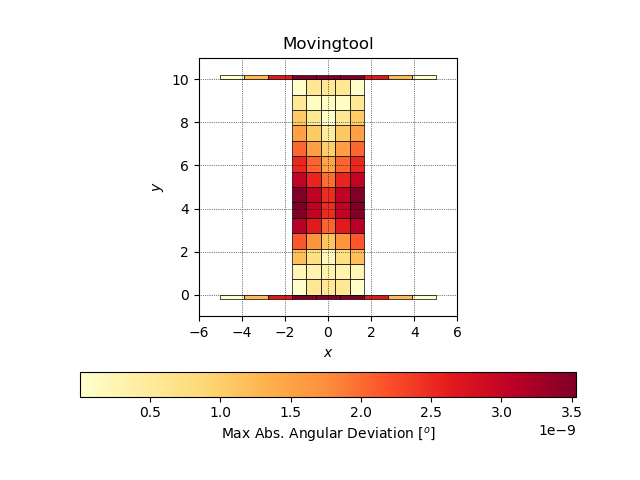

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [74]:
i = 1
fig = plt.figure()
parts_names = parts.keys()
for name, part in parts.items(): 
    mesh = part.mesh
    patches = mesh.to_polycollection(edgecolor = "black", linewidth = .5, alpha = 1.)
    stats = mesh.stats()
    patches.set_array( stats.stats.max_abs_angular_deviation )
    patches.set_cmap(mpl.cm.YlOrRd)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect("equal")
    #ax.set_xlim(mesh.nodes.coords.x.min(), mesh.nodes.coords.x.max())
    #ax.set_ylim(mesh.nodes.coords.y.min(), mesh.nodes.coords.y.max())
    ax.set_xlim(-6, 6)
    ax.set_ylim(-1,11)
    ax.add_collection(patches)
cbar = plt.colorbar(patches, orientation = "horizontal")
cbar.set_label("Max Abs. Angular Deviation [$^o$]")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.grid()
plt.title(name.title())
    #i+= 1
plt.show()


In [75]:
print("2: Processing -------------------------------------")
%time model_EF.run_simulation()

2: Processing -------------------------------------
#### RUNNING "Comp" USING SOLVER "ABAQUS"
     Analysis initiated from SIMULIA established products
     Abaqus JOB Comp
     Abaqus 3DEXPERIENCE R2018x
     Abaqus License Manager checked out the following licenses:
     Abaqus/Standard checked out 5 tokens from Flexnet server flex2-symme.univ-savoie.fr.
     <53 out of 90 licenses remain available>.
     Begin Analysis Input File Processor
     6/19/2019 2:48:19 PM
     Run pre.exe
     6/19/2019 2:48:20 PM
     End Analysis Input File Processor
     Begin Abaqus/Standard Analysis
     6/19/2019 2:48:20 PM
     Run standard.exe
     6/19/2019 2:48:27 PM
     End Abaqus/Standard Analysis
     Begin Convert MFS to SFS
     6/19/2019 2:48:27 PM
     Run SMASimUtility.exe
     6/19/2019 2:48:27 PM
     End Convert MFS to SFS
     Abaqus JOB Comp COMPLETED
  => RAN Comp: DURATION = 12.55s
Wall time: 12.6 s


In [76]:
print("3: Postprocessing ---------------------------------")
%time model_EF.postproc()
print("4: Saving model -----------------------------------")
%time model_EF.save(workdir + "model_Comp.pcklz")

3: Postprocessing ---------------------------------
#### POST-PROCESSING "Comp" USING POST-PROCESSOR "ABAQUS"
     Abaqus License Manager checked out the following license(s):
     "cae" release 6.18 from flex2-symme.univ-savoie.fr
     <5 out of 9 licenses remain available>.
  => POST-PROCESSED Comp: DURATION = 19.91s >
hist_path= ./workdir/reports/Comp_hist.hrpt
Wall time: 22.1 s
4: Saving model -----------------------------------
Wall time: 87 ms


In [20]:
model_EF = ag.utils.load(workdir + "model_Comp.pcklz")

## Simulation

## Post-Processing

### Time data


In [36]:
hist = model_EF.data["history"]
hist.head()

RF   dtot       t  step            F
0    -0.000000  0.000  0.0000     0    -0.000000
1  -365.129211 -0.010  0.0050     0  -365.129211
2  -731.016846 -0.020  0.0100     0  -731.016846
3 -1281.096560 -0.035  0.0175     0 -1281.096560
4 -2016.894040 -0.055  0.0275     0 -2016.894040

<IPython.core.display.Javascript object>


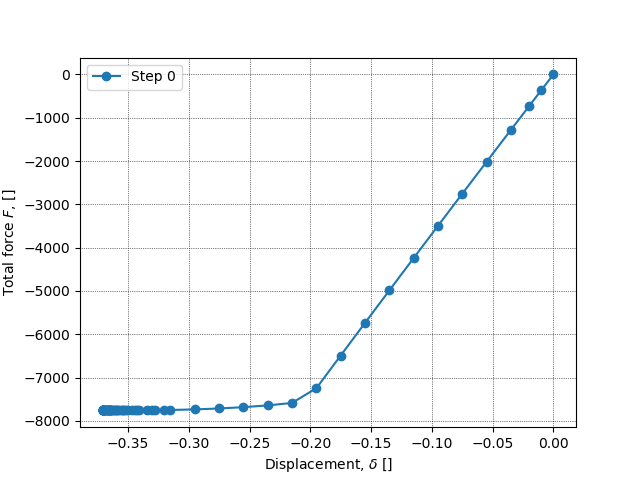

In [46]:
plt.figure()
for step, group in hist.groupby("step"):
  plt.plot(group.dtot, group.F,'o-', label = "Step {0}".format(step))
plt.grid()
plt.legend(loc = "best")
plt.ylabel("Total force $F$, []")
plt.xlabel("Displacement, $\delta$ []")
plt.show()

### Fields

In [38]:
meta=model_EF.parts["sample"].mesh.fields_metadata()
meta

frame frame_value label      part position step_label step_num
0        0           0    LE  I_SAMPLE     node   LOADING1        0
365      0           0    LE  I_SAMPLE     node   LOADING1        0
730      0           0    LE  I_SAMPLE     node   LOADING1        0
1        0           0    PE  I_SAMPLE     node   LOADING1        0
366      0           0    PE  I_SAMPLE     node   LOADING1        0
731      0           0    PE  I_SAMPLE     node   LOADING1        0
2        0           0     S  I_SAMPLE     node   LOADING1        0
367      0           0     S  I_SAMPLE     node   LOADING1        0
732      0           0     S  I_SAMPLE     node   LOADING1        0
3        0           0   Seq  I_SAMPLE     node   LOADING1        0
368      0           0   Seq  I_SAMPLE     node   LOADING1        0
733      0           0   Seq  I_SAMPLE     node   LOADING1        0
4        0           0     U  I_SAMPLE     node   LOADING1        0
369      0           0     U  I_SAMPLE     node   LOADING1        0
734      0           0     U  I_SAMPLE     node   LOADING1        0
55       1       0.005    LE  I_SAMPLE     node   LOADING1        0
420      1       0.005    LE  I_SAMPLE     node   LOADING1        0
785      1       0.005    LE  I_SAMPLE     node   LOADING1        0
56       1       0.005    PE  I_SAMPLE     node   LOADING1        0
421      1       0.005    PE  I_SAMPLE     node   LOADING1        0
786      1       0.005    PE  I_SAMPLE     node   LOADING1        0
57       1       0.005     S  I_SAMPLE     node   LOADING1        0
422      1       0.005     S  I_SAMPLE     node   LOADING1        0
787      1       0.005     S  I_SAMPLE     node   LOADING1        0
58       1       0.005   Seq  I_SAMPLE     node   LOADING1        0
423      1       0.005   Seq  I_SAMPLE     node   LOADING1        0
788      1       0.005   Seq  I_SAMPLE     node   LOADING1        0
59       1       0.005     U  I_SAMPLE     node   LOADING1        0
424      1       0.005     U  I_SAMPLE     node   LOADING1        0
789      1       0.005     U  I_SAMPLE     node   LOADING1        0
...    ...         ...   ...       ...      ...        ...      ...
340     71    0.185446    LE  I_SAMPLE     node   LOADING1        0
705     71    0.185446    LE  I_SAMPLE     node   LOADING1        0
1070    71    0.185446    LE  I_SAMPLE     node   LOADING1        0
341     71    0.185446    PE  I_SAMPLE     node   LOADING1        0
706     71    0.185446    PE  I_SAMPLE     node   LOADING1        0
1071    71    0.185446    PE  I_SAMPLE     node   LOADING1        0
342     71    0.185446     S  I_SAMPLE     node   LOADING1        0
707     71    0.185446     S  I_SAMPLE     node   LOADING1        0
1072    71    0.185446     S  I_SAMPLE     node   LOADING1        0
343     71    0.185446   Seq  I_SAMPLE     node   LOADING1        0
708     71    0.185446   Seq  I_SAMPLE     node   LOADING1        0
1073    71    0.185446   Seq  I_SAMPLE     node   LOADING1        0
344     71    0.185446     U  I_SAMPLE     node   LOADING1        0
709     71    0.185446     U  I_SAMPLE     node   LOADING1        0
1074    71    0.185446     U  I_SAMPLE     node   LOADING1        0
345     72    0.185446    LE  I_SAMPLE     node   LOADING1        0
710     72    0.185446    LE  I_SAMPLE     node   LOADING1        0
1075    72    0.185446    LE  I_SAMPLE     node   LOADING1        0
346     72    0.185446    PE  I_SAMPLE     node   LOADING1        0
711     72    0.185446    PE  I_SAMPLE     node   LOADING1        0
1076    72    0.185446    PE  I_SAMPLE     node   LOADING1        0
347     72    0.185446     S  I_SAMPLE     node   LOADING1        0
712     72    0.185446     S  I_SAMPLE     node   LOADING1        0
1077    72    0.185446     S  I_SAMPLE     node   LOADING1        0
348     72    0.185446   Seq  I_SAMPLE     node   LOADING1        0
713     72    0.185446   Seq  I_SAMPLE     node   LOADING1        0
1078    72    0.185446   Seq  I_SAMPLE     node   LOADING1   

<IPython.core.display.Javascript object>


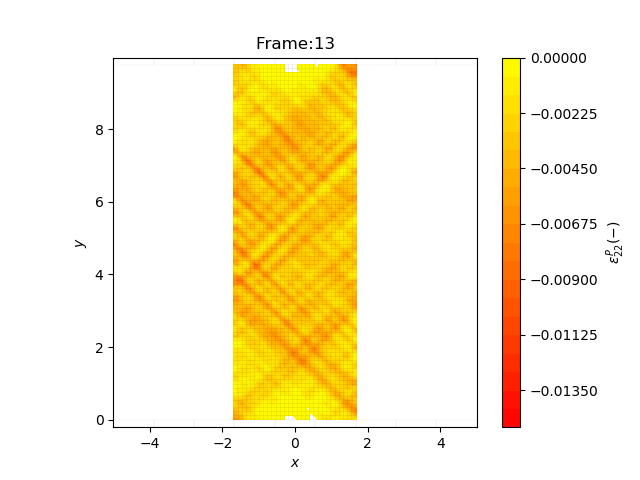

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


In [45]:
#Frame number to plot
frame_num=13
parts = {k:part.mesh.copy() for k, part in model_EF.parts.items() }

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

field_num = meta[(meta.label=='PE') & (meta.frame==frame_num)].index[0]
disp_num  = meta[(meta.label=='U')  & (meta.frame==frame_num)].index[0]
levels = np.linspace(-.015, 0.000, 21)
dispMagnification = 1.

for k, mesh in parts.items():
    
    field =mesh.fields[field_num].data.v22
    disp = mesh.fields[disp_num].data
    frame = mesh.fields[disp_num].frame
    mesh.nodes[("coords", "x")] += dispMagnification*disp.v1
    mesh.nodes[("coords", "y")] += dispMagnification*disp.v2
    tri = mesh.to_triangulation()
    patches = mesh.to_polycollection(facecolor = "none",
                                     edgecolor = "black",
                                     linewidth = .02) 
    grad = ax.tricontourf(tri, field, levels, cmap = mpl.cm.autumn, alpha = 1)
    ax.tricontour(tri, field, levels, colors = "white", linewidths = 0.01)
    #ax.tricontour(tri, field, 0, colors = "r", linewidths = 2)
    ax.add_collection(patches)

plt.title("Frame:{0}".format(frame))
ax.set_aspect("equal")
#ax.set_xlim(0, 55.)
#ax.set_ylim(-40, 20.)
cbar = plt.colorbar(grad)
cbar.set_label("$\epsilon^P_{22} (-)$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()



<IPython.core.display.Javascript object>


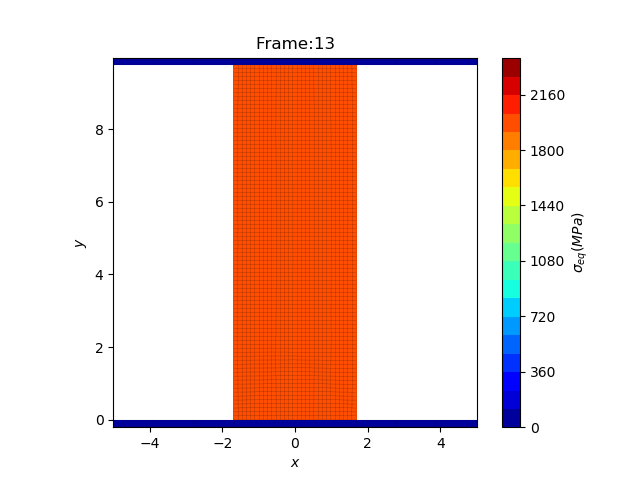

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


In [47]:
parts = {k:part.mesh.copy() for k, part in model_EF.parts.items() }

fig = plt.figure()
ax = fig.add_subplot(1,1,1)


field_num = meta[(meta.label=='Seq') & (meta.frame==frame_num)].index[0]
disp_num  = meta[(meta.label=='U')  & (meta.frame==frame_num)].index[0]
levels = np.linspace(0, 2400, 21)
dispMagnification = 1.

for k, mesh in parts.items():
    
    field =mesh.fields[field_num].data.v
    disp = mesh.fields[disp_num].data
    frame = mesh.fields[disp_num].frame
    mesh.nodes[("coords", "x")] += dispMagnification*disp.v1
    mesh.nodes[("coords", "y")] += dispMagnification*disp.v2
    tri = mesh.to_triangulation()
    patches = mesh.to_polycollection(facecolor = "none",
                                     edgecolor = "black",
                                     linewidth = .05) 
    grad = ax.tricontourf(tri, field, levels, cmap = mpl.cm.jet, alpha = 1)
    ax.tricontour(tri, field, levels, colors = "white", linewidths = 0.05)
    #ax.tricontour(tri, field, 0, colors = "r", linewidths = 2)
    ax.add_collection(patches)

plt.title("Frame:{0}".format(frame))
ax.set_aspect("equal")
#ax.set_xlim(0, 55.)
#ax.set_ylim(-40, 20.)
cbar = plt.colorbar(grad)
cbar.set_label("$\sigma_{eq} (MPa)$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()